In [21]:
import numpy as np
import pandas as pd
import openml
import pickle
import os
import sys
from meta_model.utils import ndcg_sim, ndcg, custom_sim
import matplotlib.pyplot as plt
sys.path.append("meta_model")

baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
}

In [22]:
benchmark_results = {}
benchmark_results_dir = "meta_dataset_creation/data/benchmark_results/"
clustering_algorithms = os.listdir(benchmark_results_dir)
clustering_algorithms

['kprototypes', 'haverage', 'fasterpam']

In [23]:
for algorithm in clustering_algorithms:
    print(algorithm)
    benchmark_results[algorithm] = {}
    for name in os.listdir(os.path.join(benchmark_results_dir, algorithm)):
        print("\t", name)
        benchmark_results[algorithm][name] = {}
        folder_path = os.path.join(benchmark_results_dir, algorithm, name)
        scores_dir = os.path.join(folder_path, "scores/")
        for filename in os.listdir(scores_dir):
            data_id = filename.split('.')[0]
            with open(os.path.join(scores_dir, filename), "rb") as f:
                result = pickle.load(f)
            for sim_pair in result:
                for eval_metric in result[sim_pair]:
                    if eval_metric not in benchmark_results[algorithm][name]:
                        benchmark_results[algorithm][name][eval_metric] = {}
                    if data_id not in benchmark_results[algorithm][name][eval_metric]:
                        benchmark_results[algorithm][name][eval_metric][data_id] = {}
                    benchmark_results[algorithm][name][eval_metric][data_id][sim_pair] = \
                        max([v["score"] for v in result[sim_pair][eval_metric] \
                            if eval_metric != "sil" or 0.05 <= v["params"]["gamma" if algorithm=="kprototypes" else "alpha"] <= (20 if algorithm=="kprototypes" else 0.95)])
                    # if eval_metric == "sil":
                    #     print(sim_pair, sorted(result[sim_pair][eval_metric], reverse=True, key= lambda v: v["score"])[0])
        
        for eval_metric in benchmark_results[algorithm][name]:
            benchmark_results[algorithm][name][eval_metric] = \
                pd.DataFrame.from_dict(benchmark_results[algorithm][name][eval_metric], orient='index')
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].fillna(-1)
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].replace(-1, -10)
            print(eval_metric, benchmark_results[algorithm][name][eval_metric].shape)
        
        if len(benchmark_results[algorithm][name]) > 0:
            indices = np.random.permutation(benchmark_results[algorithm][name]["acc"].shape[0])
            for eval_metric in benchmark_results[algorithm][name]:
                benchmark_results[algorithm][name][eval_metric] = benchmark_results[algorithm][name][eval_metric].iloc[indices]
            
            max_ = benchmark_results[algorithm][name]["acc"].max(axis=1)
            for eval_metric in ["acc", "ari", "purity"]:
                benchmark_results[algorithm][name][eval_metric] = benchmark_results[algorithm][name][eval_metric][max_ >= 0.75]
                print(eval_metric, benchmark_results[algorithm][name][eval_metric].shape)
            print()

kprototypes
	 from_numeric
acc (228, 120)
ari (228, 120)
purity (228, 120)
sil (228, 120)
acc (60, 120)
ari (60, 120)
purity (60, 120)

	 original
acc (182, 120)
ari (182, 120)
purity (182, 120)
sil (182, 120)
acc (73, 120)
ari (73, 120)
purity (73, 120)

haverage
	 from_numeric
	 original
acc (185, 120)
ari (185, 120)
purity (185, 120)
sil (185, 120)
acc (88, 120)
ari (88, 120)
purity (88, 120)

fasterpam
	 original
acc (185, 120)
ari (185, 120)
purity (185, 120)
sil (185, 120)
acc (62, 120)
ari (62, 120)
purity (62, 120)

	 from_numeric


In [24]:
algorithm = 'kprototypes'
eval_metric = 'acc'
benchmark_results[algorithm]["original"][eval_metric].head()

,euclidean_hamming,euclidean_eskin,euclidean_iof,euclidean_of,euclidean_jaccard,euclidean_dice,euclidean_kulsinski,euclidean_rogerstanimoto,euclidean_russellrao,euclidean_sokalmichener,...,euclidean_co-oc,manhattan_co-oc,chebyshev_co-oc,sqeuclidean_co-oc,canberra_co-oc,mahalanobis_co-oc,cosine_co-oc,pearson_co-oc,lorentzian_co-oc,divergence_co-oc
339,0.777778,0.777778,0.777778,0.777778,0.666667,0.666667,0.666667,0.583333,0.666667,0.583333,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
40710,0.811881,0.792079,0.811881,0.815182,0.825083,0.825083,0.828383,0.828383,0.825083,0.828383,...,0.825083,0.818482,0.825083,0.828383,0.818482,0.825083,0.828383,0.825083,0.821782,0.818482
1116,0.537739,0.537739,0.537739,0.802516,0.537739,0.537739,0.537739,0.537739,0.537739,0.537739,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
947,0.518784,0.518784,0.518784,0.518784,0.518784,0.518784,0.518784,0.518784,0.518784,0.518784,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
38,0.711559,0.710498,0.712354,0.876193,0.710498,0.710498,0.710498,0.710498,0.710498,0.710498,...,0.876193,0.876193,0.876193,0.876193,0.886267,0.876193,0.876193,0.876193,0.876193,0.880435


In [25]:
dataset_statistics = ["n_instances", "n_features",
                      "dim", "num_on_cat", "n_num_att", "n_cat_att"]
attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",  # "kurtosis_num_att", "skewness_num_att",
        "card_cat_att", "entropy_cat_att",
        "covariance",
    ]
]

isolation_forest = [f"isolation_forest_{i}" for i in range(10)]

proposed_attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        # "kurtosis_squared_num_att", "skewness_squared_num_att",
        "means_squared_num_att", "std_squared_num_att",
        # "kurtosis_internal_product_num_att", "skewness_internal_product_num_att",
        "means_internal_product_num_att", "std_internal_product_num_att",
        "mutual_info_cat_att",
        "std_freq_cat_att"
    ]
]

In [26]:
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.ensemble import IsolationForest
mixed_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/original/meta_features.csv", index_col="id").drop_duplicates()
# mixed_meta_df = mixed_meta_df[(np.abs(stats.zscore(mixed_meta_df)) < 3).all(axis=1)]
indices = IsolationForest(random_state=0).fit_predict(mixed_meta_df.to_numpy())>0
mixed_meta_df = mixed_meta_df.iloc[indices]
mixed_meta_df.index = mixed_meta_df.index.astype(str)
print("Number of meta features:", mixed_meta_df.shape[1])
print("Number of instances:", mixed_meta_df.shape[0])

Number of meta features: 61
Number of instances: 159


In [27]:
numeric_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/from_numeric/meta_features.csv", index_col="id").drop_duplicates()
numeric_meta_df.index = numeric_meta_df.index.astype(str)
print("Number of meta features:", numeric_meta_df.shape[1])
print("Number of instances:", numeric_meta_df.shape[0])

Number of meta features: 61
Number of instances: 500


In [28]:
from sklearn.metrics import pairwise_distances
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_Y = benchmark_results[algorithm]["original"][eval_metric][index.isin(mixed_meta_df.index)].to_numpy()
if eval_metric in ["acc", "purity"]:
    mixed_Yn = np.array([y/max(y) for y in mixed_Y])
    mixed_Yn[mixed_Yn > 0] **= 4
    mixed_Yn[mixed_Yn<0] = -1
elif eval_metric == "ari":
    mixed_Yn = np.array([(y+0.5)/max(y+0.5) for y in mixed_Y])
    mixed_Yn[mixed_Yn > 0] **= 4
    mixed_Yn[mixed_Yn<0] = -1
else:
    mixed_Yn = np.array([(y+1)/max(y+1) for y in mixed_Y])
    mixed_Yn[mixed_Yn > 0] **= 4
    mixed_Yn[mixed_Yn<0] = -1

# index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
# numeric_Y = benchmark_results[algorithm]["from_numeric"][eval_metric][index.isin(numeric_meta_df.index)].to_numpy()
# numeric_Yn = np.array([y/max(y) for y in numeric_Y])
# numeric_Yn[numeric_Yn>0] **= 4
# numeric_Yn[numeric_Yn<0] = -1

In [29]:
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_X = mixed_meta_df.loc[[i for i in index if i in mixed_meta_df.index]].to_numpy()
# landmark = []
# for data_id in [i for i in index if i in mixed_meta_df.index]:
#     filename = os.path.join(benchmark_results_dir, f"{algorithm}/original/scores/{data_id}.pickle")
#     with open(filename, "rb") as f:
#         obj = pickle.load(f)
#         scores = [v["score"] for v in obj[baseline_pairs[algorithm]]['sil']]
#         # print(len(scores))
#         landmark.append(scores)
# landmark = np.array(landmark)
# mixed_X = np.c_[mixed_X, landmark]

# index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
# numeric_X = numeric_meta_df.loc[[i for i in index if i in numeric_meta_df.index]].to_numpy()
sc = StandardScaler().fit(mixed_X) # StandardScaler().fit(np.concatenate((mixed_X, numeric_X))) #
mixed_X = sc.transform(mixed_X) # mixed_X/mixed_X.shape[1] #
# numeric_X = sc.transform(numeric_X) # numeric_X/numeric_X.shape[1] #

mixed_X.shape #, numeric_X.shape

(62, 61)

In [30]:
X = mixed_X # np.concatenate((mixed_X, numeric_X))
X2 = X[:, [i for i in range(mixed_meta_df.shape[1]) if mixed_meta_df.columns.values[i] in dataset_statistics+attributes_statistics]]
Y = mixed_Y # np.concatenate((mixed_Y, numeric_Y))
Yn = mixed_Yn # np.concatenate((mixed_Yn, numeric_Yn))

In [31]:
selected_datasets = np.array([i for i in range(mixed_X.shape[0])])
print(len(selected_datasets))

62


In [32]:
pca = PCA()
X_pca = pca.fit_transform(mixed_X)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
n_features = 0
for i, v in enumerate(cum_sum_eigenvalues):
    if v > 0.98:
        n_features = i + 1
        break
X_pca = X_pca[:, :n_features]

In [33]:
from meta_model.utils import ndcg
from meta_model.ranking import ALL_MODELS, scorer_func
from meta_model.ranking_tree import RankingTree
from sklearn.model_selection import KFold, cross_val_predict

n_splits=10
predictions = {}
predictions["AR"] = np.zeros(shape=(len(selected_datasets), 120))

model = ALL_MODELS["KNN"]().cross_val_fit(X2[selected_datasets], Y[selected_datasets], n_splits=n_splits) #
predictions["LMF-KNN"] = cross_val_predict(model, X2[selected_datasets], Y[selected_datasets], cv=n_splits)
print(scorer_func(Y[selected_datasets], predictions["LMF-KNN"]))

model = ALL_MODELS["KNN"]().cross_val_fit(X[selected_datasets], Y[selected_datasets], n_splits=n_splits) #
predictions["AMF-KNN"] = cross_val_predict(model, X[selected_datasets], Y[selected_datasets], cv=n_splits)
print(scorer_func(Y[selected_datasets], predictions["AMF-KNN"]))

# model = ALL_MODELS["MDTree"]().cross_val_fit(X[selected_datasets], Y[selected_datasets], n_splits=n_splits) #
# predictions["AMF-MDTree"] = cross_val_predict(model, X[selected_datasets], Y[selected_datasets], cv=n_splits)
# print(scorer_func(Y[selected_datasets], predictions["AMF-MDTree"]))

model = ALL_MODELS["RF"]().cross_val_fit(X[selected_datasets], Y[selected_datasets], n_splits=n_splits) #
predictions["AMF-RF"] = cross_val_predict(model, X[selected_datasets], Y[selected_datasets], cv=n_splits)
print(scorer_func(Y[selected_datasets], predictions["AMF-RF"]))

# model = ALL_MODELS["RT"]().cross_val_fit(X_pca[selected_datasets], Y[selected_datasets], n_splits=n_splits) #
# predictions["AMF-RT"] = cross_val_predict(model, X_pca[selected_datasets], Y[selected_datasets], cv=n_splits)
# print(scorer_func(Y[selected_datasets], predictions["AMF-RT"]))

for train, test in KFold(n_splits=n_splits).split(X[selected_datasets]):
    predictions["AR"][test] = np.array([
        [np.mean(yj) for yj in Y[train].T]
        for _ in test
    ])
    # predictions["AMF-RT"][test] = ALL_MODELS["RT"](max_depth=4).fit(X_pca[selected_datasets][train], Y[selected_datasets][train]).predict(X_pca[selected_datasets][test]) #
    # print(".", end="")
# print()
# print(scorer_func(Y[selected_datasets], predictions["AMF-RT"]))
print(scorer_func(Y[selected_datasets], predictions["AR"]))

0.7870909536038186
0.7846169466528061
0.7786606368807313
0.7748721733457359


In [34]:
# from sklearn.datasets import make_regression
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# model = ALL_MODELS["PR-DTree"]().cross_val_fit(X[selected_datasets], Y[selected_datasets], n_splits=n_splits)
# predictions["AMF-GBoost"] = cross_val_predict(model, X[selected_datasets], Y[selected_datasets], cv=n_splits, n_jobs=-1)
# fitness = scorer_func(Y[selected_datasets], predictions["AMF-GBoost"])
# print(fitness)

In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from meta_model.ranking import ALL_MODELS
from sklearn.metrics import make_scorer
from meta_model.ranking import scorer, scorer_func
import pygad

# scorer_funcs = [
#     lambda yt, yp: np.mean([max(y[y>-1][np.argsort(-yp[i][y>-1])[:k]]) for i, y in enumerate(yt)])
#     for k in [1, 5]
# ]
# scorer_func = lambda yt, yp: np.mean(ndcg(yt, yp, p=5))

metrics = ["euclidean", "manhattan", "cosine"]
weights = ["uniform", "distance"]

def on_generation(ga_instance):
    _, fitness, _ = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)
    print(f"GEN: {ga_instance.generations_completed}, Best fitness: {fitness}")

def fitness_func(ga_instance, solution, solution_idx):
    selected_feats = np.array(solution[:X.shape[1]])>0
    n_neighbors = solution[X.shape[1]]
    metric = metrics[solution[X.shape[1]+1]]
    w = weights[solution[X.shape[1]+2]]
    # pca = PCA()
    # X_pca = pca.fit_transform(X[selected_datasets][:, selected_feats])
    # exp_var_pca = pca.explained_variance_ratio_
    # cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    # n_features = 0
    # for i, v in enumerate(cum_sum_eigenvalues):
    #     if v > 0.98:
    #         n_features = i + 1
    #         break
    # X_pca = X_pca[:, :n_features]
    knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
    # knn = knn.cross_val_fit(X[selected_datasets][:, selected_feats], Y[selected_datasets], n_splits=n_splits, n_jobs=-1)
    fitness = 0
    for i in range(10):
        Y_pred = cross_val_predict(knn, X[selected_datasets][:, selected_feats], Y[selected_datasets], cv=KFold(n_splits=n_splits, shuffle=True, random_state=i), n_jobs=-1)
        # fitness = sum([f(Y[selected_datasets], Y_pred)/(1+i)**2 for i,f in enumerate(scorer_funcs)])
        fitness += scorer_func(Y[selected_datasets], Y_pred)
    fitness /= 10
    return fitness #- 1e-3*sum(selected_feats)

# def fitness_func(ga_instance, solution, solution_idx):
#     Y_pred = np.zeros(shape=Y.shape)
#     s = X.shape[1] + 3
#     for j in range(Y.shape[1]):
#         l = solution[j*s:(j+1)*s]
#         selected_feats = np.array(l[:X.shape[1]])>0
#         n_neighbors = l[X.shape[1]]
#         metric = metrics[l[X.shape[1]+1]]
#         w = weights[l[X.shape[1]+2]]
#         knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
#         Y_pred[:, j] = cross_val_predict(knn, X[selected_datasets][:, selected_feats], Y[selected_datasets, j], cv=10, n_jobs=-1)
#     fitness = scorer_func(Y[selected_datasets], Y_pred)
#     return fitness - 1e-5*sum(selected_feats)

fitness_function = fitness_func

num_generations = 600
sol_per_pop = 8
num_parents_mating = sol_per_pop//2
num_genes = X.shape[1] + 3
gene_type = int
gene_space = [[0, 1] for _ in range(X.shape[1])] + [range(1, 31), range(3), [0, 1]]
# num_genes = (X.shape[1] + 3)*Y.shape[1]
# gene_type = int
# gene_space = ([[0, 1] for _ in range(X.shape[1])] + [range(1, 31), range(3), [0, 1]])*Y.shape[1]

parent_selection_type = "sss"
keep_elitism = 1
crossover_type = "uniform"
crossover_probability = 0.95
mutation_type = "random"
mutation_probability = 0.05
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       crossover_probability=crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       on_generation=on_generation,
                    #    parallel_processing=['process', sol_per_pop],
                    #    save_best_solutions=True
                    )
ga_instance.run()

GEN: 1, Best fitness: 0.8081080005390529
GEN: 2, Best fitness: 0.8100574439380743
GEN: 3, Best fitness: 0.8100574439380743
GEN: 4, Best fitness: 0.8100574439380743
GEN: 5, Best fitness: 0.8103813652158735
GEN: 6, Best fitness: 0.8103813652158735
GEN: 7, Best fitness: 0.8111274878665657
GEN: 8, Best fitness: 0.8111274878665657
GEN: 9, Best fitness: 0.8111274878665657
GEN: 10, Best fitness: 0.8111274878665657
GEN: 11, Best fitness: 0.8111274878665657
GEN: 12, Best fitness: 0.8111274878665657
GEN: 13, Best fitness: 0.8111274878665657
GEN: 14, Best fitness: 0.8111274878665657
GEN: 15, Best fitness: 0.8111274878665657
GEN: 16, Best fitness: 0.811973544316387
GEN: 17, Best fitness: 0.8121785610857684
GEN: 18, Best fitness: 0.8121785610857684
GEN: 19, Best fitness: 0.8131839191516492
GEN: 20, Best fitness: 0.8131839191516492
GEN: 21, Best fitness: 0.8142671135145786
GEN: 22, Best fitness: 0.8145274863987325
GEN: 23, Best fitness: 0.8160416519582355
GEN: 24, Best fitness: 0.8160416519582355
GE

In [20]:
from meta_model.ranking import scorer, scorer_func
solution_knn, solution_fitness_knn, solution_idx_knn = ga_instance.best_solution()
selected_features_knn = np.array(solution_knn[:X.shape[1]])>0
n_neighbors = solution_knn[X.shape[1]]
metric = metrics[solution_knn[X.shape[1]+1]]
w = weights[solution_knn[X.shape[1]+2]]
model = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
# model = model.cross_val_fit(X[selected_datasets][:, selected_features_knn], Y[selected_datasets], n_splits=n_splits, n_jobs=-1)
predictions["AMF-FS-KNN"] = cross_val_predict(model, X[selected_datasets][:, selected_features_knn], Y[selected_datasets], cv=10, n_jobs=-1)
fitness = scorer_func(Y[selected_datasets], predictions["AMF-FS-KNN"])
print(sum(selected_features_knn))
print(mixed_meta_df.columns[selected_features_knn])
print(fitness)

21
Index(['n_instances', 'n_features', 'dim', 'n_num_att', 'min_means_num_att',
       'q1_means_num_att', 'q3_means_num_att', 'q1_std_num_att',
       'mean_std_num_att', 'min_means_squared_num_att',
       'q1_means_squared_num_att', 'q1_std_squared_num_att',
       'q3_means_internal_product_num_att', 'min_std_internal_product_num_att',
       'min_covariance', 'q1_covariance', 'max_covariance', 'n_cat_att',
       'q1_entropy_cat_att', 'mean_mutual_info_cat_att',
       'min_std_freq_cat_att'],
      dtype='object')
0.8201553881185508


In [79]:
# sim_pair = np.argmax(mixed_Y[0]) #sim_pairs_index["manhattan_hamming"]
# features = [i for i, v in enumerate(selected_features) if v]
# n_rows = len(features)
# n_cols = len(features)
# plt.figure(figsize=(2*n_cols, 2*n_rows))
# for i in range(n_rows - 1):
#     for j in range(i+1, n_cols):
#         plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
#         plt.scatter(mixed_X[:,features[i]], mixed_X[:,features[j]], c=Y[:mixed_X.shape[0], sim_pair], cmap="YlOrRd")
#         # plt.scatter(mixed_X[:,features[i]], mixed_X[:,features[j]], c=sim_matrix[0, :mixed_X.shape[0]], cmap="YlOrRd", vmin=0.5, vmax=1)
#         plt.xticks([])
#         plt.yticks([])
# plt.tight_layout(h_pad=0, w_pad=0)
# plt.show()

In [80]:
# # Scale the dataset; This is very important before you apply PCA
# #
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# #
# # Instantiate PCA
# #
# pca = PCA()
# #
# # Determine transformed features
# #
# X_pca = pca.fit_transform(mixed_X)
# #
# # Determine explained variance using explained_variance_ration_ attribute
# #
# exp_var_pca = pca.explained_variance_ratio_
# #
# # Cumulative sum of eigenvalues; This will be used to create step plot
# # for visualizing the variance explained by each principal component.
# #
# cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# #
# # Create the visualization plot
# #
# plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='best')
# plt.tight_layout()
# plt.show()

In [44]:
metrics = ["euclidean", "manhattan", "cosine"]
weights = ["uniform", "distance"]

def on_generation(ga_instance):
    _, fitness, _ = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)
    print(f"GEN: {ga_instance.generations_completed}, Best fitness: {fitness}")
    
def fitness_func(ga_instance, solution, solution_idx):
    selected_feats = np.array(solution[:X2.shape[1]])>0
    n_neighbors = solution[X2.shape[1]]
    metric = metrics[solution[X2.shape[1]+1]]
    w = weights[solution[X2.shape[1]+2]]
    knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
    # knn, fitness = knn.cross_val_fit(X2[selected_datasets][:,selected_feats], Y[selected_datasets], n_splits=n_splits, n_jobs=-1, return_cv_scores=True)
    Y_pred = cross_val_predict(knn, X2[selected_datasets][:, selected_feats], Y[selected_datasets], cv=n_splits, n_jobs=-1)
    fitness = scorer_func(Y[selected_datasets], Y_pred)
    return fitness #- 1e-4*sum(selected_feats)

fitness_function = fitness_func

num_generations = 600
sol_per_pop = 8
num_parents_mating = sol_per_pop//2
num_genes = X2.shape[1] + 3
gene_type = int
gene_space = [[0, 1] for _ in range(X2.shape[1])] + [range(1, 31), range(3), [0, 1]]

parent_selection_type = "sss"
keep_elitism = 1
crossover_type = "uniform"
crossover_probability = 0.95
mutation_type = "random"
mutation_probability = 0.05

ga_instance2 = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       crossover_probability=crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       on_generation=on_generation,
                    #    parallel_processing=['process', 16],
                    #    save_best_solutions=True
                    )
ga_instance2.run()

GEN: 1, Best fitness: 0.8144786039334151
GEN: 2, Best fitness: 0.8168623983851125
GEN: 3, Best fitness: 0.8171362075363907
GEN: 4, Best fitness: 0.8177524274220711
GEN: 5, Best fitness: 0.8231620638511158
GEN: 6, Best fitness: 0.8231620638511158
GEN: 7, Best fitness: 0.8231620638511158
GEN: 8, Best fitness: 0.8231620638511158
GEN: 9, Best fitness: 0.8231620638511158
GEN: 10, Best fitness: 0.8231620638511158
GEN: 11, Best fitness: 0.8231620638511158
GEN: 12, Best fitness: 0.8231620638511158
GEN: 13, Best fitness: 0.8231620638511158
GEN: 14, Best fitness: 0.823290533735141
GEN: 15, Best fitness: 0.8237857357966758
GEN: 16, Best fitness: 0.8244668729777954
GEN: 17, Best fitness: 0.8244668729777954
GEN: 18, Best fitness: 0.8244668729777954
GEN: 19, Best fitness: 0.8244727239734717
GEN: 20, Best fitness: 0.8244727239734717
GEN: 21, Best fitness: 0.8244727239734717
GEN: 22, Best fitness: 0.8244727239734717
GEN: 23, Best fitness: 0.8244727239734717
GEN: 24, Best fitness: 0.8244727239734717
GE

In [45]:
solution_knn2, solution_fitness_knn2, solution_idx_knn2 = ga_instance2.best_solution()
selected_features_knn2 = np.array(solution_knn2[:X2.shape[1]])>0
n_neighbors = solution_knn2[X2.shape[1]]
metric = metrics[solution_knn2[X2.shape[1]+1]]
w = weights[solution_knn2[X2.shape[1]+2]]
model = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
model = model.cross_val_fit(X2[selected_datasets][:, selected_features_knn2], Y[selected_datasets], n_splits=n_splits, n_jobs=-1)
predictions["LMF-FS-KNN"] = cross_val_predict(model, X2[selected_datasets][:, selected_features_knn2], Y[selected_datasets], cv=n_splits, n_jobs=-1)
fitness = scorer_func(Y[selected_datasets], predictions["LMF-FS-KNN"])
print(sum(selected_features_knn2))
# print(mixed_meta_df.columns[selected_features_knn2])
print(fitness)

11
0.8273192392889787


In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from meta_model.ranking import ALL_MODELS
from sklearn.metrics import make_scorer
from meta_model.ranking import scorer, scorer_func
import pygad
from joblib import Parallel, delayed

max_features = [None, "sqrt", "log2"]

def on_generation(ga_instance):
    _, fitness, _ = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)
    print(f"GEN: {ga_instance.generations_completed}, Best fitness: {fitness}")

def fitness_func(ga_instance, solution, solution_idx):
    selected_feats = np.array(solution[:X.shape[1]])>0
    min_samples_leaf = solution[X.shape[1]]
    n_estimators = solution[X.shape[1]+1]
    # max_f = max_features[solution[X.shape[1]+1]]
    model = ALL_MODELS["RF"](min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)
    Y_pred = cross_val_predict(model, X[selected_datasets][:, selected_feats], Y[selected_datasets], cv=n_splits, n_jobs=-1)
    fitness = scorer_func(Y[selected_datasets], Y_pred)
    return fitness #- 2e-4*sum(selected_feats)

# def fitness_func(ga_instance, solution, solution_idx):
#     Y_pred = np.zeros(shape=Y.shape)
#     s = X.shape[1] + 2
#     def fit_predict(j):
#         l = solution[j*s:(j+1)*s]
#         selected_feats = np.array(l[:X.shape[1]])>0
#         min_samples_leaf = l[X.shape[1]]
#         max_f = max_features[l[X.shape[1]+1]]
#         model = ALL_MODELS["DTree"](min_samples_leaf=min_samples_leaf, max_features=max_f)
#         return cross_val_predict(model, X[selected_datasets][:, selected_feats], Y[selected_datasets, j], cv=n_splits)
#     list_ret = Parallel(n_jobs=-1)(delayed(fit_predict)(j) for j in range(Y.shape[1]))
#     for j, yj in enumerate(list_ret):
#         Y_pred[:, j] = yj
#     fitness = scorer_func(Y[selected_datasets], Y_pred)
#     return fitness

fitness_function = fitness_func
num_generations = 100
num_parents_mating = 4
sol_per_pop = 8
num_genes = X.shape[1] + 2
gene_type = int
gene_space = [[0, 1] for _ in range(X.shape[1])] + [range(1, 31), range(10, 110, 20)] #range(len(max_features))
# num_genes = (X.shape[1] + 2)*Y.shape[1]
# gene_type = int
# gene_space = ([[0, 1] for _ in range(X.shape[1])] + [range(1, 31), range(len(max_features))])*Y.shape[1]

parent_selection_type = "sss"
keep_elitism = 1
crossover_type = "uniform"
crossover_probability = 0.9
mutation_type = "random"
mutation_probability = 0.1

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       crossover_probability=crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       on_generation=on_generation,
                    #    parallel_processing=['process', 32],
                    #    save_best_solutions=True
                    )
ga_instance.run()

In [28]:
solution_mdtree, solution_fitness_mdtree, solution_idx_mdtree = ga_instance.best_solution()
selected_features_mdtree = np.array(solution_mdtree[:X.shape[1]])>0
min_samples_leaf = solution_mdtree[X.shape[1]]
n_estimators = solution_mdtree[X.shape[1]+1]
# max_f = max_features[solution[X.shape[1]+1]]
model = ALL_MODELS["RF"](min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)
predictions["AMF-FS-RF"] = cross_val_predict(model, X[selected_datasets][:, selected_features_mdtree], Y[selected_datasets], cv=10, n_jobs=-1)
fitness = scorer_func(Y[selected_datasets], predictions["AMF-FS-RF"])
print(sum(selected_features_mdtree))
print(mixed_meta_df.columns[selected_features_mdtree])
print(fitness)

32
Index(['n_instances', 'n_features', 'dim', 'num_on_cat', 'q1_means_num_att',
       'q1_std_num_att', 'max_std_num_att', 'min_means_squared_num_att',
       'max_means_squared_num_att', 'min_std_squared_num_att',
       'q1_std_squared_num_att', 'mean_std_squared_num_att',
       'q3_std_squared_num_att', 'max_std_squared_num_att',
       'q1_means_internal_product_num_att',
       'max_means_internal_product_num_att',
       'min_std_internal_product_num_att', 'mean_std_internal_product_num_att',
       'min_covariance', 'max_covariance', 'n_cat_att', 'min_card_cat_att',
       'max_card_cat_att', 'min_entropy_cat_att', 'q3_entropy_cat_att',
       'max_entropy_cat_att', 'q1_mutual_info_cat_att',
       'max_mutual_info_cat_att', 'min_std_freq_cat_att',
       'q1_std_freq_cat_att', 'mean_std_freq_cat_att', 'max_std_freq_cat_att'],
      dtype='object')
0.6005375582967828


In [77]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from meta_model.ranking import ALL_MODELS
from sklearn.metrics import make_scorer
from meta_model.ranking import scorer, scorer_func
import pygad
from joblib import Parallel, delayed

max_features = [None, "sqrt", "log2"]

def on_generation(ga_instance):
    _, fitness, _ = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)
    print(f"GEN: {ga_instance.generations_completed}, Best fitness: {fitness}")

def fitness_func(ga_instance, solution, solution_idx):
    selected_feats = np.array(solution[:X2.shape[1]])>0
    min_samples_leaf = solution[X2.shape[1]]
    max_f = max_features[solution[X2.shape[1]+1]]
    model = ALL_MODELS["DTree"](min_samples_leaf=min_samples_leaf, max_features=max_f)
    Y_pred = cross_val_predict(model, X2[selected_datasets][:, selected_feats], Y[selected_datasets], cv=n_splits, n_jobs=-1)
    fitness = scorer_func(Y[selected_datasets], Y_pred)
    return fitness #- 2e-4*sum(selected_feats)

# def fitness_func(ga_instance, solution, solution_idx):
#     Y_pred = np.zeros(shape=Y.shape)
#     s = X.shape[1] + 2
#     def fit_predict(j):
#         l = solution[j*s:(j+1)*s]
#         selected_feats = np.array(l[:X.shape[1]])>0
#         min_samples_leaf = l[X.shape[1]]
#         max_f = max_features[l[X.shape[1]+1]]
#         model = ALL_MODELS["DTree"](min_samples_leaf=min_samples_leaf, max_features=max_f)
#         return cross_val_predict(model, X[selected_datasets][:, selected_feats], Y[selected_datasets, j], cv=n_splits)
#     list_ret = Parallel(n_jobs=-1)(delayed(fit_predict)(j) for j in range(Y.shape[1]))
#     for j, yj in enumerate(list_ret):
#         Y_pred[:, j] = yj
#     fitness = scorer_func(Y[selected_datasets], Y_pred)
#     return fitness

fitness_function = fitness_func
num_generations = 500
num_parents_mating = 4
sol_per_pop = 8
num_genes = X2.shape[1] + 2
gene_type = int
gene_space = [[0, 1] for _ in range(X2.shape[1])] + [range(1, 31), range(len(max_features))]
# num_genes = (X.shape[1] + 2)*Y.shape[1]
# gene_type = int
# gene_space = ([[0, 1] for _ in range(X.shape[1])] + [range(1, 31), range(len(max_features))])*Y.shape[1]

parent_selection_type = "sss"
keep_elitism = 1
crossover_type = "uniform"
crossover_probability = 0.9
mutation_type = "random"
mutation_probability = 0.1

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_elitism=keep_elitism,
                       crossover_type=crossover_type,
                       crossover_probability=crossover_probability,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
                       on_generation=on_generation,
                    #    parallel_processing=['process', 32],
                    #    save_best_solutions=True
                    )
ga_instance.run()

GEN: 1, Best fitness: 0.5785339324589315
GEN: 2, Best fitness: 0.5785339324589315
GEN: 3, Best fitness: 0.5823233428380367
GEN: 4, Best fitness: 0.5823233428380367
GEN: 5, Best fitness: 0.5823233428380367
GEN: 6, Best fitness: 0.5869213679351656
GEN: 7, Best fitness: 0.5869213679351656
GEN: 8, Best fitness: 0.5869213679351656
GEN: 9, Best fitness: 0.5870982344714885
GEN: 10, Best fitness: 0.5878510354959201
GEN: 11, Best fitness: 0.5878510354959201
GEN: 12, Best fitness: 0.5892163349839976
GEN: 13, Best fitness: 0.5892163349839976
GEN: 14, Best fitness: 0.5903792650284965
GEN: 15, Best fitness: 0.5903792650284965
GEN: 16, Best fitness: 0.5903792650284965
GEN: 17, Best fitness: 0.5903792650284965
GEN: 18, Best fitness: 0.5903792650284965
GEN: 19, Best fitness: 0.5903792650284965
GEN: 20, Best fitness: 0.5903792650284965
GEN: 21, Best fitness: 0.5903792650284965
GEN: 22, Best fitness: 0.5903792650284965
GEN: 23, Best fitness: 0.5903792650284965
GEN: 24, Best fitness: 0.5903792650284965
G

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
selected_features_mdtree = np.array(solution[:X2.shape[1]])>0
min_samples_leaf = solution[X2.shape[1]]
max_f = max_features[solution[X2.shape[1]+1]]
model = ALL_MODELS["DTree"](min_samples_leaf=min_samples_leaf, max_features=max_f)
predictions["LMF-FS-DTree"] = cross_val_predict(model, X2[selected_datasets][:, selected_features_mdtree], Y[selected_datasets], cv=10, n_jobs=-1)
fitness = scorer_func(Y[selected_datasets], predictions["LMF-FS-DTree"])
print(sum(selected_features_mdtree))
# print(mixed_meta_df.columns[selected_features_mdtree])
print(fitness)

In [46]:
similarity_pairs = benchmark_results[algorithm]["original"][eval_metric].columns
sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))

ndcg_ranks = [1, 3, 5, 10, 15, 20]
n_bests = [1, 3, 5, 10]
ndcg_scores = {
    model_name: {p: np.zeros(len(selected_datasets)) for p in ndcg_ranks}
    for model_name in predictions
} #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

lb_scores = np.zeros(len(selected_datasets))
rb_scores = {k: np.zeros(len(selected_datasets)) for k in n_bests}
mb_scores = np.zeros(len(selected_datasets))
model_scores = {
    model_name: {k: np.zeros(len(selected_datasets)) for k in n_bests}
    for model_name in predictions
} #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for p in ndcg_ranks:
        ndcg_scores[name][p] = ndcg(Yn[selected_datasets], Y_pred, p=p)

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for k in n_bests:
        model_scores[name][k] = np.array(
            [max(y[y > -1][np.argsort(-Y_pred[i][y > -1])[:k]]) for i, y in enumerate(Y[selected_datasets])])

for k in n_bests:
    rb_scores[k] = np.array(
        [max(np.random.choice(y[y > -1], k)) for y in Y[selected_datasets]])

lb_scores = Y[selected_datasets][:, sim_pairs_index[baseline_pairs[algorithm]]]
mb_scores = np.array([max(y) for y in Y[selected_datasets]])

/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


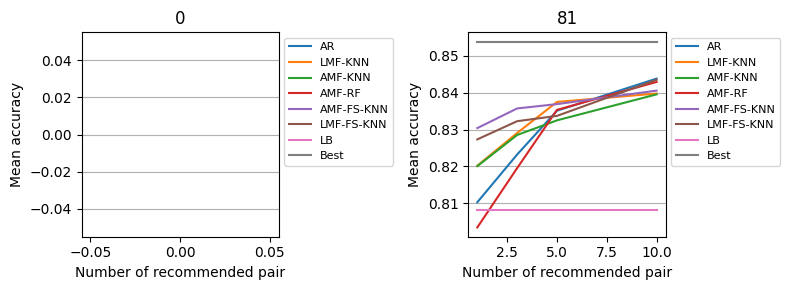

In [47]:
import matplotlib.pyplot as plt

list_indices = [
    [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) < 0.0], #test_index[i] in base_datasets and # i in test and
    [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0.]
]
rows, cols = 1, len(list_indices)
plt.figure(figsize=(cols*4, rows*3))
subplot_num = 1
exclude = [] #"KNN with aug.", "RF with aug." - "KNN", "RF", "AE+KNN", "AE+RF"
for indices in list_indices:
    scores = {k:v for k, v in model_scores.items() if k not in exclude} 
    # scores["RB"] = rb_scores
    scores["LB"] = lb_scores
    scores["Best"] = mb_scores

    y = {key: [] for key in scores}

    for name, score in scores.items():
        for k in n_bests:
            u = score[indices] if name in ["LB", "Best"] else score[k][indices]
            y[name].append(np.mean(u))

    plt.subplot(rows, cols, subplot_num)
    for name, values in y.items():
        plt.plot(n_bests, values, label=name)
    plt.ylabel("Mean accuracy")
    plt.xlabel("Number of recommended pair")
    # plt.ylim((0.67, 0.9))
    plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
    plt.grid(axis="y")
    plt.title(len(indices))
    subplot_num += 1
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

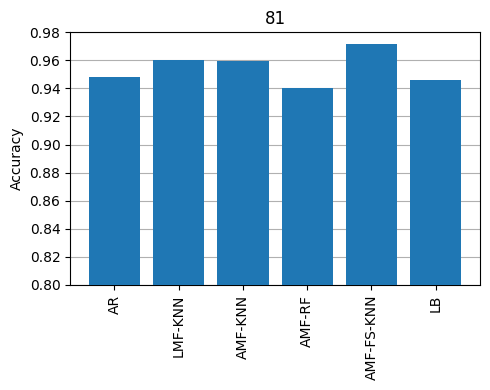

In [25]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 1
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = np.mean((u+0.)/(best_scores+0.))

plt.figure(figsize=(5, 4))
plt.bar(y.keys(), y.values(), zorder=5)
plt.ylabel("Accuracy")
plt.ylim((0.8, 0.98))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

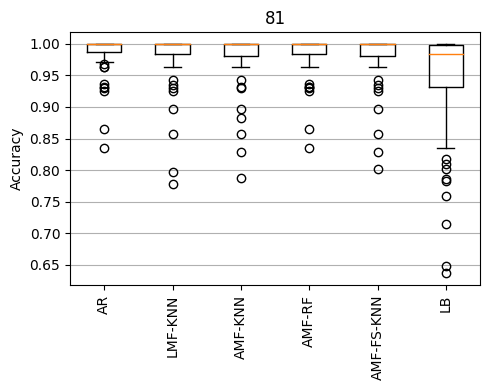

In [26]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y[selected_datasets]) if np.mean(1 - y[y>0]/max(y[y>0])) >= 0.]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 10
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = (u+0.)/(best_scores+0.)

plt.figure(figsize=(5, 4))
plt.boxplot(y.values(), labels=y.keys())
plt.ylabel("Accuracy")
# plt.ylim((0.67, 0.9))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

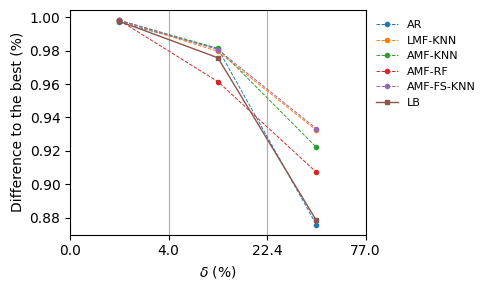

In [41]:
baselines = ["LB"]
k = 1
plt.figure(figsize=(5, 3))
# if j == 0:
#     ax = plt.subplot(2, 1, 1)
# else:
#     ax = plt.subplot(2, 1, 2)
# res = results[algo]

best_scores = mb_scores
y = {}
l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn[selected_datasets])]
x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])

x[0] -= 1e-4
diff = 0.025
list_indices = [
    [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn[selected_datasets])]
    for r, xr in enumerate(x[:-1])
] #

for model_name, scores in model_scores.items():
    y[model_name] = []
    for i, indices in enumerate(list_indices):
        # new_ind = [val and lb_scores[j] >, 0, for j, val in enumerate(indices)]
        v = np.mean(((scores[k])/best_scores)[indices])
        y[model_name].append(v)

y["LB"] = []
for i, indices in enumerate(list_indices):
    v = np.mean(((lb_scores)/best_scores)[indices])
    y["LB"].append(v)

n_bar = len(y)
w = 0.8/n_bar
z = np.arange(len(x))
i = 0
max_ = np.zeros(len(list_indices))
min_ = np.ones(len(list_indices))*100
for model_name, values in y.items():
    max_ = np.maximum(max_, values)
    min_ = np.minimum(min_, values)
    # plt.plot(z[:-1]+0.5, values, "--", linewidth=0.7, label=None, alpha=1 if i<6 else 0.7, zorder=10)
    # plt.scatter(z[:-1]+0.5, values, label=model_name, s=[10*np.log(sum(val)) for val in list_indices], alpha=1 if i<6 else 0.7, zorder=10)
    plt.plot(z[:-1]+0.5, values, "--o" if model_name not in baselines else "-s", linewidth=0.7 if model_name not in baselines else 1, label=model_name, markersize=3, zorder=10)
    i += 1

for ind, val in enumerate(list_indices):
    if ind >= 1:
        plt.annotate(f"{max_[ind]:.2g}%", (z[ind]+0.5, max_[ind]+1), fontsize=8, ha="center", va="top")

# plt.bar(x[1:]-diff/2, [50 for _ in diff], width=diff[0], zorder=0, label=None, color="None", edgecolor="gray")

plt.xlim((z[0], z[-1]))
plt.ylabel("Difference to the best (%)")
plt.xticks(z, [f"{max(0, val*100):.1f}" for val in x])
# plt.ylim((min(min_)-1, max(max_)+1))
plt.grid(axis="x")
plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
plt.xlabel("$\delta$ (%)")

# if j == 0:
#     plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
# if j == 1: 
#     plt.xlabel("$\delta$ (%)")
# j += 1
# plt.title(names[algo], y=0.83)

plt.tight_layout()
# if savedir is not None:
#     plt.savefig(os.path.join(savedir, f"diff_best_delta_{algo}_{k}.pdf"))
plt.show()

In [ ]:
from scipy.stats import wilcoxon

model_names = ["KNN", "AMF-FS-KNN"]
baselines = ["LB", "RB", "ARB"]
y = {k:{} for k in model_names}
y_ndcg = {k:{} for k in model_names}

for model_name in model_names:
    scores = model_scores[model_name][1]
    baseline_scores = model_scores["AR"][1]
    s, p = wilcoxon(scores, baseline_scores, alternative="greater")
    y[model_name]["(top-1) ARB"] = f"{p:.3f}"

    baseline_scores = ndcg_scores["AR"][10]
    scores = ndcg_scores[model_name][10]
    s, p = wilcoxon(scores, baseline_scores, alternative="greater")
    y[model_name]["(NDCG) ARB"] = f"{p:.3f}"

print(pd.DataFrame.from_dict(y, orient='index'))

KeyError: 'KNN'

In [ ]:
# Save results

